<div><a href="https://knodis-research-group.github.io/"><img style="float: right; width: 128px; vertical-align:middle" src="https://knodis-research-group.github.io/knodis-logo_horizontal.png" alt="KNODIS logo" /></a>

# Clasificación de texto con CNN<a id="top"></a>

<i><small>Última actualización: 2025-03-14</small></i></div>

***

## Introducción

En el procesamiento del lenguaje natural (NLP, del inglés _natural language processing_), una tarea muy típica es la clasificación de textos. En esta tarea, un texto dado se clasifica según su significado. A menudo se utiliza, por ejemplo, para el problema del análisis de sentimientos.

Se trata de un problema denominado _many-to-one_, es decir, uno en el que el tamaño de la secuencia de entrada es $T_X = 1$, pero el tamaño de la secuencia de salida es $T_Y = 1$.

## Objetivos

Vamos a hacer un experimento en el que utilizaremos el conjunto de datos de reseñas de amazon para una tarea de análisis de sentimiento. A partir de los datos de reseñas y valoraciones, identificaremos si una reseña es positiva, neutra o negativa, y para ello utilizaremos una primera aproximación utilizando un modelo de redes neuronales convolucionales.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [1]:
import collections
import gzip
import re
import requests
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import torch
import torchmetrics

import utils

Using device: cuda


También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

Comprobamos y creamos los directorios necesarios para almacenar los datos y resultados.

In [3]:
TEMP_PATH = pathlib.Path('tmp')
TEMP_PATH.mkdir(exist_ok=True)

***

## Parámetros globales

Comenzaremos definiendo los parámetros que utilizaremos, como la longitud máxima de las secuencias y la dimensión de los vectores de palabras, para que  el _notebook_ se adapte lo más fácilmente posible.

In [4]:
N_EPOCHS = 20           # Número de iteraciones de entrenamiento
BATCH_SIZE = 32768      # Número de ejemplos por batch
EMBEDDING_DIM = 50      # Dimensiones de nuestro embedding (50, 100, 200 o 300)
MAX_VOCAB_SIZE = 20000  # Tamaño máximo de nuestro vocabulario
MAX_SEQUENCE_LEN = 128  # Longitud máxima de las secuencias de palabras

## Preprocesamiento de datos

Vamos a cargar los datos de entrenamiento, que consistirán en los datos de reseñas de Amazon de la categoría «Música digital». Estos datos se utilizarán para entrenar nuestro modelo de clasificación.

In [5]:
DATASET_URL = 'https://github.com/blazaid/aprendizaje-profundo/raw/refs/heads/gh-pages/Datasets/Digital_Music_5.json.gz'
DATASET = pathlib.Path('tmp/Digital_Music_5.json')

print(f"Downloading dataset to {DATASET.resolve()}")
if not DATASET.exists():
    with requests.get(DATASET_URL, stream=True) as response:
        response.raise_for_status()
        with gzip.GzipFile(fileobj=response.raw) as f_gz:
            with DATASET.open("wb") as f:
                shutil.copyfileobj(f_gz, f)
else:
    print("File already exists! Nice")

print("Loading text corpus")
corpus = pd.read_json(DATASET, lines=True)
corpus.dropna(subset=['overall', 'reviewText'], inplace=True)
corpus.head()

print("Done")

File already exists! Nice
Loading text corpus
Done


Aquí nos centraremos en construir y entrenar un modelo basado en CNN para clasificar textos. Aunque aquí utilizamos solo un conjunto de entrenamiento, en una aplicación real sería fundamental contar con conjuntos de validación y prueba para evaluar correctamente el rendimiento del modelo.

### Preparando la entrada a nuestro modelo

Utilizaremos las reseñas de texto como entrada del modelo. Para ello, extraeremos las reseñas y transformaremos las valoraciones en etiquetas numéricas: asignaremos $0$ a reseñas con valoraciones bajas, $1$ a las intermedias y $2$ a las altas. Este paso permitirá que el modelo aprenda a distinguir entre opiniones positivas, negativas y neutrales.

In [6]:
x_train = corpus['reviewText'].astype(str).str.strip()
y_train = corpus['overall'].astype(int).replace({
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 2,
})
num_classes = len(set(y_train))

print(f"Training input shape:  {x_train.shape}")
print(f"Training output shape: {y_train.shape}")
print(f"No. of classes:        {num_classes}")

Training input shape:  (169623,)
Training output shape: (169623,)
No. of classes:        3


A continuación, ya que trabajamos con texto, crearemos una función un poco más compleja que las anteriores que pasará a minúscula y extraerá palabras, separando la puntuación. Esta función nos ayudará a construir un vocabulario a partir del conjunto de entrenamiento.

In [7]:
def tokenizer(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b|[^\w\s]', text, re.UNICODE)
    return tokens

counter = collections.Counter()
for text in x_train:
    counter.update(tokenizer(text))

De entre todas las palabras, seleccionamos las más frecuentes hasta alcanzar un límite definido. Reservamos _tokens_ especiales para el relleno (`<PAD>`) y para palabras desconocidas (`<UNK>`), lo cual es importante para el manejo de entradas de longitud fija.

In [8]:
special_tokens = ['<PAD>', '<UNK>']

most_common = counter.most_common(MAX_VOCAB_SIZE - len(special_tokens))
vocab_words = [word for word, _ in most_common]

vocab = {token: i for i, token in enumerate(special_tokens)}
for i, word in enumerate(vocab_words, start=len(special_tokens)):
    vocab[word] = i

vocab_size = len(vocab)
print(f'Tamaño del vocabulario: {vocab_size}')

Tamaño del vocabulario: 20000


Con la relación token$\rightarrow$índice creada, definiremos una función que transforma cada texto en una secuencia de índices. Se aplicará relleno o truncado para que todas las secuencias tengan la misma longitud.

In [9]:
def text_to_sequence(text, vocab, max_len=MAX_SEQUENCE_LEN):
    tokens = tokenizer(text)
    seq = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(seq) > max_len:
        seq = seq[:max_len]
    else:
        seq = seq + [vocab['<PAD>']] * (max_len - len(seq))
    return seq

Por último, implementamos un nuevo `Dataset`, que se encargará de gestionar y transformar los datos de las reseñas en secuencias numéricas, asociándolas con sus respectivas etiquetas. Este objeto será usado por el `DataLoader` para el proceso de entrenamiento.

In [10]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, vocab, max_len=MAX_SEQUENCE_LEN):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.vocab = vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        seq = text_to_sequence(self.texts[idx], self.vocab, self.max_len)
        return torch.tensor(seq, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


dataset = TextDataset(x_train, y_train, vocab, MAX_SEQUENCE_LEN)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Uso de _embeddings_ preentrenados en nuestro modelo

Ya hemos visto que, a la hora de construir un modelo lingüístico, un aspecto importante es la representación de las palabras. Para captar el significado semántico de las palabras, utilizamos _embeddings_ de palabras, que son representaciones vectoriales de palabras en un espacio donde cada una de las muchas dimensiones representan una característica semántica.

Esta vez, en lugar de entrenar nuestros _embeddings_ desde cero, aprovecharemos uno preentrenado, _Global Vectors for Word Representation_ (GLoVe), entrenado con un conjunto de datos de más de 6.000 millones de tokens. Cuenta con varios vectores de palabras preentrenados, por lo que los utilizaremos en <http://nlp.stanford.edu/data/glove.6B.zip>.

In [11]:
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = pathlib.Path('tmp/glove.6B.zip')

# Download the compressed GloVe dataset (if you don't already have it)
if not GLOVE_FILE.exists():
    print('Downloading GloVe ...', end='')
    with open(GLOVE_FILE, 'wb') as f:
        r = requests.get(GLOVE_URL, allow_redirects=True)
        f.write(r.content)
    print('OK')

# Unzip it in the directory 'glove'.
print('Unpacking ...', end='')
shutil.unpack_archive(GLOVE_FILE, 'tmp')
print('OK')

Unpacking ...OK


Mediante su uso podemos aprovechar la gran cantidad de conocimiento codificado en estos _embeddings_, lo que seguramente mejore (y mucho)el rendimiento de nuestro modelo lingüístico.

Ahora carguemos el _embedding_ de la dimensión especificada en la configuración. El archivo se compone de líneas de tuplas, donde el primer elemento es la palabra (en texto) y el segundo es ese vector de palabras

In [12]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(f'tmp/glove.6B.{EMBEDDING_DIM}d.txt') as f:
    for line in f:
        word, vector = line.split(maxsplit=1)
        word2vec[word] = np.fromstring(vector,'f', sep=' ')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 50-d embedding... done (400000 word vectors loaded)


Bueno, $400.000$ _tokens_ son bastantes. Como nuestro vocabulario es menor, vamos a crear una capa de incrustación más pequeña, del tamaño de nuestro vocabulario. Para ello, incluiremos en ésta sólo los vectores de las palabras que nos devolverá la capa `TextVectorization`.

Comenzaremos creando la matriz de incrustación con los vectores del guante

In [18]:
print('Creating embedding matrix with GloVe vectors... ', end='')

# Our newly created embedding: a matrix of zeros
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

ko_words = 0
for word, idx in vocab.items():
    word_glove = 'unk' if word == '<UNK>' else word
    vector = word2vec.get(word_glove)
    if vector is not None:
        embedding_matrix[idx] = vector
    else:
        ko_words += 1

print(f'done ({ko_words} out of {len(vocab)} words unassigned)')
print(f'Embedding matrix shape {embedding_matrix.shape}')

Creating embedding matrix with GloVe vectors... done (736 out of 20000 words unassigned)
Embedding matrix shape (20000, 50)


Bueno, al parecer hay muchas palabras que no tienen correspondencia en el _embedding_ descargada. Después de todo $400000$ _tokens_ igual no eran tantos después de todo.

## Clasificación basada en redes neuronales convolucionales

Utilizaremos una CNN para extraer características relevantes de las reseñas. Al representar cada texto como una «imagen» de una sola fila, la CNN puede identificar patrones y relaciones importantes entre las palabras, lo que (esperamos) ayude a la capacidad de clasificación.

In [14]:
class CNNClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, n_classes, embedding_matrix, dropout=0.5):
        super().__init__()

        # Capa de embedding con los vectores de palabras ya preentrenados
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = torch.nn.Parameter(
            torch.tensor(embedding_matrix),
            requires_grad=False,  # Al ser False estos parámetros no se entrenan
        )
        
        self.convs = torch.nn.ModuleList([
            torch.nn.LazyConv1d(out_channels=n_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.LazyLinear(out_features=n_classes)
        
    def forward(self, x):
        x = self.embedding(x)          # (B, seq_len, embedding_dim)
        x = x.float().transpose(1, 2)  # (B, embedding_dim, seq_len)

        conv_outs = [torch.relu(conv(x)) for conv in self.convs]
        pool_outs = [
            torch.nn.functional.adaptive_max_pool1d(conv_out, 1).squeeze(2) 
            for conv_out in conv_outs
        ]

        x = torch.cat(pool_outs, dim=1)  # (B, n_filters*len(filter_sizes))
        x = self.dropout(x)
        logits = self.fc(x)                   # (B, n_classes)
        return logits

cnn_model = CNNClassifier(
    vocab_size,
    EMBEDDING_DIM,
    n_filters=32,
    filter_sizes = [3, 4, 5],
    n_classes=num_classes,
    embedding_matrix=embedding_matrix,
)
print(cnn_model)

CNNClassifier(
  (embedding): Embedding(20000, 50)
  (convs): ModuleList(
    (0): LazyConv1d(0, 32, kernel_size=(3,), stride=(1,))
    (1): LazyConv1d(0, 32, kernel_size=(4,), stride=(1,))
    (2): LazyConv1d(0, 32, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): LazyLinear(in_features=0, out_features=3, bias=True)
)


Ahora pasamos a entrenar el modelo. Esperemos que todo salga bien.

In [15]:
history = utils.train(
    cnn_model,
    train_loader,
    n_epochs=N_EPOCHS,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(cnn_model.parameters()),
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes),
)

Epoch 1/20 (36.01s), Train loss: 1.0769, Train metric: 0.3386
Epoch 2/20 (36.80s), Train loss: 0.4601, Train metric: 0.3339
Epoch 3/20 (37.42s), Train loss: 0.3701, Train metric: 0.3333
Epoch 4/20 (37.46s), Train loss: 0.3727, Train metric: 0.3333
Epoch 5/20 (37.79s), Train loss: 0.3709, Train metric: 0.3333
Epoch 6/20 (37.92s), Train loss: 0.3552, Train metric: 0.3337
Epoch 7/20 (38.08s), Train loss: 0.3371, Train metric: 0.3337
Epoch 8/20 (38.83s), Train loss: 0.3221, Train metric: 0.3337
Epoch 9/20 (38.46s), Train loss: 0.3140, Train metric: 0.3334
Epoch 10/20 (38.40s), Train loss: 0.3082, Train metric: 0.3335
Epoch 11/20 (38.35s), Train loss: 0.3014, Train metric: 0.3338
Epoch 12/20 (38.49s), Train loss: 0.2961, Train metric: 0.3338
Epoch 13/20 (38.58s), Train loss: 0.2916, Train metric: 0.3334
Epoch 14/20 (38.18s), Train loss: 0.2873, Train metric: 0.3336
Epoch 15/20 (38.50s), Train loss: 0.2844, Train metric: 0.3336
Epoch 16/20 (39.05s), Train loss: 0.2818, Train metric: 0.3335
E

Echemos un vistazo al progreso del entrenamiento:

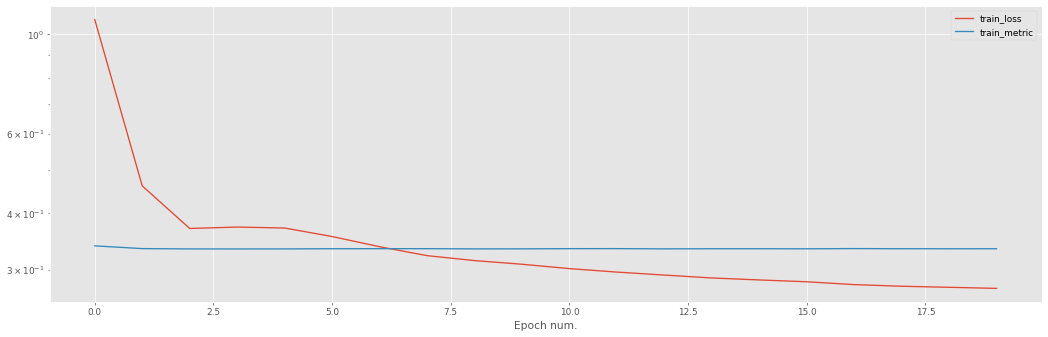

In [16]:
pd.DataFrame(history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

## Evaluación de nuestro modelo

Veamos ahora cómo interpreta el sentimiento de una reseña buena, regular y mala extraída del sitio web de amazon.

In [17]:
good = ("My nephew is on the autism spectrum and likes to fidget with things so I knew this toy would be a hit. "
        "Was concerned that it may not be \"complex\" enough for his very advanced brain but he really took to it. "
        "Both him (14 yrs) and his little brother (8 yrs) both enjoyed playing with it throughout Christmas morning. "
        "I'm always happy when I can find them something unique and engaging.")

poor = ("I wasn't sure about this as it's really small. I bought it for my 9 year old grandson. "
        "I was ready to send it back but my daughter decided it was a good gift so I'm hoping he likes it. "
        "Seems expensive for the price though to me.")

evil = ("I just wanted to follow up to say that I reported this directly to the company and had no response. "
        "I have not gotten any response from my review. The level of customer service goes a long way when an item "
        "you purchase is defective and this company didn’t care to respond. No I am even more Leary about ordering "
        "anything from this company. I never asked for a refund or replacement since I am not able to return it. "
        "I’m just wanted to let them know that this was a high dollar item and I expected it to be a quality item. "
        "Very disappointed! I bought this for my grandson for Christmas. He loved it and played with it a lot. "
        "My daughter called to say that the stickers were peeling on the corners. I am not able to take it from my "
        "grandson because he is autistic and wouldn’t understand. I just wanted to warn others who are wanting to get "
        "this. Please know that this is a cool toy and it may not happen to yours so it is up to you.")

def predict_text(text, model, vocab):
    model.eval()
    seq = text_to_sequence(text, vocab, MAX_SEQUENCE_LEN)
    seq_tensor = torch.tensor(seq, dtype=torch.long).unsqueeze(0)  # crear batch de 1
    with torch.no_grad():
        logits = model(seq_tensor)
        pred = logits.argmax(dim=1).item()
    return pred

print(f'Good was classified as {predict_text(good, cnn_model, vocab)}')
print(f'Poor was classified as {predict_text(poor, cnn_model, vocab)}')
print(f'Evil was classified as {predict_text(evil, cnn_model, vocab)}')

Good was classified as 2
Poor was classified as 2
Evil was classified as 2


## Conclusiones

Hemos demostrado cómo utilizar una red neuronal convolucional para clasificar texto, en concreto, reseñas de productos como buenas, medias o malas. También hemos analizado las ventajas de utilizar incrustaciones de palabras preentrenadas, que pueden ayudar a mejorar el rendimiento del modelo aprovechando las relaciones semánticas entre las palabras del corpus preentrenado. También exploramos la capa TextVectorization, que proporciona una forma flexible de preprocesar datos de texto y convertirlos en vectores numéricos.

Se trata de un ejemplo que puede servir de punto de partida para multitud de proyectos de NLP.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>